# Outline
    preprocessing
        impute base on 2 hour avg
        shift 1 - 12 columns
        feature engineering
    trainning
        model (Nested CV) for each hour, drop specific columns since pm2.5 column with missing value are different for each hour
            Stack
                knn
                rf
                LR
                XGBoost
                SVM

Yes, you can rank the most predictive features without retraining the model, provided your trained model supports feature importance retrieval. Here's how you can do it depending on the type of model you're using:

---

### **1. Tree-Based Models (e.g., Random Forest, XGBoost)**
Tree-based models inherently compute feature importance during training, so you can directly access this information.

#### **Accessing Feature Importance**
```python
# Assuming 'model' is your trained Random Forest or XGBoost model
importances = model.feature_importances_

# Get feature names if available (for pipelines, extract preprocessed features)
feature_names = X_train.columns  # or use the pipeline step output if transformed

# Pair feature names with their importance
feature_importance = list(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Ranked Features by Importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")
```

---

### **2. Logistic Regression**
Logistic regression uses weights (coefficients) to determine the influence of features. You can rank features by the magnitude of their coefficients.

#### **Accessing Feature Coefficients**
```python
# Assuming 'model' is your trained Logistic Regression model
coefficients = model.coef_[0]  # Access the coefficients for the positive class

# Pair feature names with their coefficients
feature_importance = list(zip(feature_names, coefficients))

# Sort features by absolute coefficient value
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
print("Ranked Features by Coefficient Magnitude:")
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient:.4f}")
```

---

### **3. SVM (with Linear Kernel)**
For linear SVMs, you can access the coefficients of the decision boundary, similar to logistic regression.

#### **Accessing Feature Coefficients**
```python
# Assuming 'model' is your trained SVC with a linear kernel
coefficients = model.coef_[0]  # Access the coefficients

# Pair feature names with their coefficients
feature_importance = list(zip(feature_names, coefficients))

# Sort features by absolute coefficient value
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
print("Ranked Features by Coefficient Magnitude:")
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient:.4f}")
```

---

### **4. K-Nearest Neighbors (KNN)**
KNN does not compute feature importance inherently because it is a non-parametric model. However, you can estimate feature importance using techniques like permutation importance or feature contribution analysis.

#### **Permutation Importance**
Permutation importance involves shuffling a feature's values and measuring the impact on model performance.

```python
from sklearn.inspection import permutation_importance

# Assuming 'model' is your trained KNN model
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1)

# Get feature importances
importances = result.importances_mean

# Pair feature names with their importances
feature_importance = list(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Ranked Features by Permutation Importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")
```

---

### **5. Using SHAP (Model-Agnostic Feature Importance)**
**SHAP (SHapley Additive exPlanations)** is a popular method for explaining predictions and analyzing feature importance across any model.

#### **Example with SHAP**
```python
import shap

# Create a SHAP explainer (model-agnostic or model-specific)
explainer = shap.Explainer(model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)
```

---

### **6. Feature Importance in a Pipeline**
If you are using a pipeline, ensure you extract the feature names after preprocessing to match the transformed data.

#### **Extracting Feature Names from a Pipeline**
```python
# Get the preprocessor step
preprocessor = pipeline.named_steps['preprocessor']

# Retrieve feature names after preprocessing
feature_names = preprocessor.transformers_[0][2]  # Adjust index based on transformers

# Access feature importance as shown earlier for your model
```

---

### **Conclusion**
- **Tree-based models** and **linear models** provide direct access to feature importance through attributes like `.feature_importances_` or `.coef_`.
- **Non-parametric models (e.g., KNN)** require additional techniques like permutation importance or SHAP.
- You can extract and rank feature importance directly from the trained model, avoiding retraining.

If you'd like, I can help implement this based on your specific model or data!

In [78]:
import pandas as pd

file_path = 'data/data.csv'
data = pd.read_csv(file_path, index_col=0)

## data visuallization

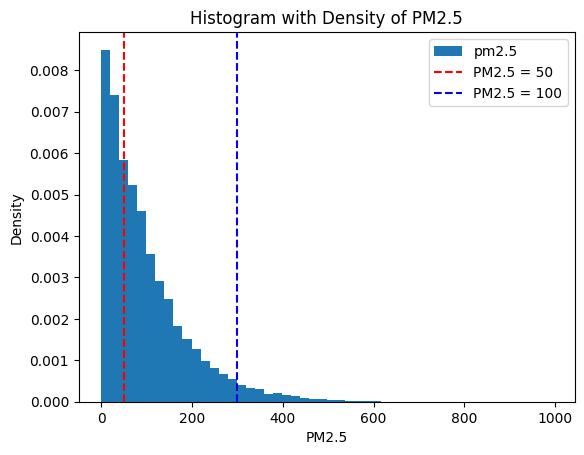

In [79]:
import matplotlib.pyplot as plt

# Adjusted the number of bins to be finer (thinner) by increasing the number
data['pm2.5'].plot(kind='hist', bins=50, density=True, title='Histogram with Density of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Density')
plt.axvline(x=50, color='r', linestyle='--', label='PM2.5 = 50')
plt.axvline(x=300, color='b', linestyle='--', label='PM2.5 = 100')
plt.legend()
plt.show()

In [80]:
# Calculate the percentage of pm2.5 values greater than or equal to 50
pm25_gte_50 = (data['pm2.5'] >= 50).mean() * 100
print(f"Percentage of PM2.5 values >= 50: {pm25_gte_50:.2f}%")

# Calculate the percentage of pm2.5 values greater than or equal to 100
pm25_gte_100 = (data['pm2.5'] >= 300).mean() * 100
print(f"Percentage of PM2.5 values >= 300: {pm25_gte_100:.2f}%")

Percentage of PM2.5 values >= 50: 59.49%
Percentage of PM2.5 values >= 300: 4.05%


In [81]:
daily_hour_counts = data.groupby(['year', 'month', 'day']).size()
missing_hours = daily_hour_counts[daily_hour_counts != 24]
missing_hours
# no missing hours

Series([], dtype: int64)

## preprocessing

In [82]:
data['pm2.5'] = data['pm2.5'].interpolate()

In [83]:
# Creating 12 new columns for future PM2.5 levels, 1 hour to 12 hours ahead
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode the 'cbwd' column
data = pd.get_dummies(data, columns=['cbwd'])

In [84]:
# Calculate the total number of rows with any missing values before dropping
missing_rows_before = data.isna().any(axis=1).sum()
print(f'missing rows before: {missing_rows_before}')
# Drop rows where any cell from 'pm2.5' to 'pm2.5_12_hour_after' is missing
data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

missing rows before: 36


In [85]:
# Calculate the index to split the data at 85% for training and 15% for testing
split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)


# Split the data into training and test sets
data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_train:split_index_test]

# Displaying sizes of the new datasets
print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

Training Data Size: 21894
Test Data Size: 15325


In [86]:
print(data_train.isnull().sum())

year                   0
month                  0
day                    0
hour                   0
pm2.5                  0
DEWP                   0
TEMP                   0
PRES                   0
Iws                    0
Is                     0
Ir                     0
pm2.5_1_hour_after     0
pm2.5_2_hour_after     0
pm2.5_3_hour_after     0
pm2.5_4_hour_after     0
pm2.5_5_hour_after     0
pm2.5_6_hour_after     0
pm2.5_7_hour_after     0
pm2.5_8_hour_after     0
pm2.5_9_hour_after     0
pm2.5_10_hour_after    0
pm2.5_11_hour_after    0
pm2.5_12_hour_after    0
cbwd_NE                0
cbwd_NW                0
cbwd_SE                0
cbwd_cv                0
dtype: int64


In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Prepare training and test data (drop the labels and year columns)
X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# Define numerical columns (replace these with the actual numerical column names in your dataset)
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# ColumnTransformer to normalize numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # Normalize numerical columns
    ],
    remainder='passthrough'  # Keep other columns as is
)

## training
    Note: the models in the notebook are fitted only once using predetermined hyperparameters from NestedCV, code with NCV are included also as scripts

In [93]:
import pandas as pd

# List of classifiers
classifiers = ['svc', 'rf', 'nn', 'xgb', 'logistic']
predictions = {}

# Load predictions from CSV files
for clf in classifiers:
    predictions[clf] = pd.read_csv(f'./outputs/{clf}_pred.csv')

hourly_predictions = []

for hour in range(1, 13):
    df_hour = pd.DataFrame()
    for clf in classifiers:
        # Get predictions for the current hour
        df_hour[clf] = predictions[clf].iloc[:, hour - 1].reset_index(drop=True)
    # Add the true label from data_test
    df_hour['True Label'] = data_test[f'pm2.5_{hour}_hour_after'].reset_index(drop=True)
    # Append the DataFrame to the list
    hourly_predictions.append(df_hour)

c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\jojo1\anaconda3\envs\python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning

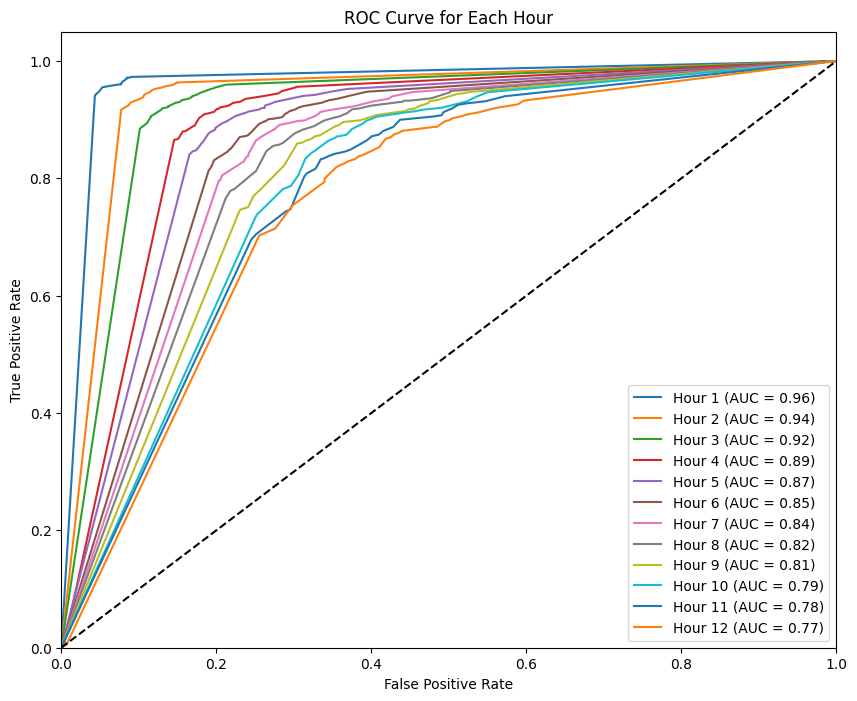

Hour 1: F1 Score = 0.96
Hour 2: F1 Score = 0.94
Hour 3: F1 Score = 0.92
Hour 4: F1 Score = 0.90
Hour 5: F1 Score = 0.88
Hour 6: F1 Score = 0.87
Hour 7: F1 Score = 0.86
Hour 8: F1 Score = 0.85
Hour 9: F1 Score = 0.84
Hour 10: F1 Score = 0.84
Hour 11: F1 Score = 0.83
Hour 12: F1 Score = 0.81


In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score, roc_curve, auc

import matplotlib.pyplot as plt

# Initialize lists to store f1 scores and ROC curve data
f1_scores = []
roc_curves = []

# Iterate over each hour
for hour in range(12):
    # Get the dataframe for the current hour
    df_hour = hourly_predictions[hour]
    
    # Define features and label
    X = df_hour.drop(columns=['True Label'])
    y = df_hour['True Label'] >= 50
    
    # Split the data into training and test sets
    split_index = int(0.8 * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Train the XGBoost model
    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate the f1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f'Hour {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Hour')
plt.legend(loc='lower right')
plt.show()

# Print the f1 scores
for i, f1 in enumerate(f1_scores):
    print(f'Hour {i+1}: F1 Score = {f1:.2f}')